<a href="https://colab.research.google.com/github/akhilagrawal1001/ResNet/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Dense, Input

In [14]:
# To create a callback for avoiding overfitting in the model
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
def add_common(input):
  input = BatchNormalization()(input)
  input = LeakyReLU()(input)

  return input

In [16]:
# There are two kinds of residual blocks possible

#This is an identity block where the input and residual are already in same shape.
'''
  # x = input_tensor
  # kernel_size = the kernel_size required for convulations
  # channels = number of channels in input /or/ residual since the are same XD.
  # repetitions = number of identitiy blocks to be made
'''
def iden(x, kernel_size, channels, repetitions):
  
  for i in range(repetitions):
    shortcut = x
    # padding is kept same so that dimensions before and after convulation is same.
    x = Conv2D(channels, kernel_size, padding='same')(x)
    x = add_common(x)
    x = Conv2D(channels, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = LeakyReLU()(x)

  return x
# This is a change residual block where input and residual are in different shape.

'''
  # x = input_tensor
  # kernel_size = the kernel_size required for convulations
  # out_channels = number of channels in *residual* tensor
  # stride =  striding if any used to obtain the residual from input
'''
def change(x, kernel, out_channels, stride = (1,1)):
  shortcut = x

  x = Conv2D(out_channels, kernel, padding='same', strides=stride)(x)
  x = add_common(x)
  x = Conv2D(out_channels, kernel, padding='same')(x)
  x = BatchNormalization()(x)

  # out_strid = (int(round(x.shape[1] / shortcut.shape[1])), int(round(x.shape[2] / shortcut.shape[2])))
  
  shortcut = Conv2D(out_channels, (1, 1), strides=stride, padding='same')(shortcut)
  shortcut = BatchNormalization()(shortcut)

  x = layers.add([x, shortcut])
  x = LeakyReLU()(x)

  return x



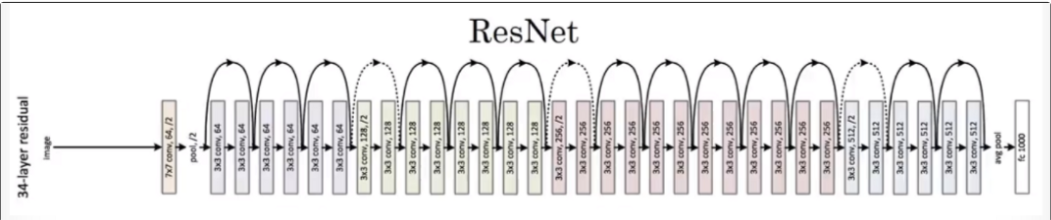

The above picture is of 34-layer Residual Neural Network, ResNet34 as given in the research paper.

It has the following network structure(Sequentially):


*   1 Conv layer of 64 channels
*   1 Pooling layer with (2, 2) stride
*   3 indentity residual blocks with 64 channels
*   1 change residual block with 128 output_channels
*   3 identity residual blocks with 128 channels
*   1 change residual block with 256 output channels
*   5 identity residual blocks with 256 channels
*   1 change residual block with 512 channels
*   2 identity residual blocks with 512 channels

Identity Residual Block and Change Residual Block are defined as functions iden() and change() respectively



In [17]:
# This is our model function, that takes training_images as input tensor, and, 
# outputs the model prediction of that input.

def res_model(x):
  x =  Conv2D(64, (7, 7), padding='same', strides=(2, 2))(x)
  x = MaxPool2D(strides=(2, 2), padding='same')(x)
  x = iden(x, (3, 3), 64, 3)
  
  x = change(x, (3, 3), 128, (2,2))
  x = iden(x, (3,3), 128, 3)
  
  x = change(x, (3, 3), 256, (2,2))
  x = iden(x, (3,3), 256, 5)
  
  x = change(x, (3, 3), 512, (2,2))
  x = iden(x, (3,3), 512, 2)

  x = GlobalAveragePooling2D()(x)
  # 10 neurons due to 10 different labels in labels of cifar10 dataset
  x = Dense(10, activation='softmax')(x)

  return x

In [18]:
img_tensor = Input(shape=[32, 32, 3])
out = res_model(img_tensor)

model = models.Model(inputs=[img_tensor], outputs=[out])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 8, 8, 64)     36928       max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [19]:
cifar = tf.keras.datasets.cifar10
(training_images, training_labels), (test_images, test_labels) = cifar.load_data()

# Normalise the image so that each pixel in each channel has value in the range [0, 1)
training_images = training_images / 255.0
test_images = test_images / 255.0

In [20]:
# Obtain validation data from the training data (first 5000 out of 50000 elements)
val_img = training_images[:5000]
val_label = training_labels[:5000]

training_images = training_images[5000:]
training_labels = training_labels[5000:]

In [21]:
print('Training image shape:' , training_images[0].shape)

Training image shape: (32, 32, 3)


In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
callback1 = myCallback()
hist = model.fit(training_images, training_labels, epochs=40, validation_data=(val_img, val_label), callbacks=[callback1])

Epoch 1/40
1407/1407 [==============================] - 86s 37ms/step - loss: 1.6606 - accuracy: 0.4128 - val_loss: 14.6316 - val_accuracy: 0.2020
Epoch 2/40
1407/1407 [==============================] - 51s 36ms/step - loss: 1.3011 - accuracy: 0.5445 - val_loss: 2.0938 - val_accuracy: 0.4578
Epoch 3/40
1407/1407 [==============================] - 51s 36ms/step - loss: 1.1413 - accuracy: 0.6058 - val_loss: 1.8207 - val_accuracy: 0.4262
Epoch 4/40
1407/1407 [==============================] - 51s 36ms/step - loss: 0.9871 - accuracy: 0.6598 - val_loss: 1.0063 - val_accuracy: 0.6440
Epoch 5/40
1407/1407 [==============================] - 51s 36ms/step - loss: 0.8969 - accuracy: 0.6898 - val_loss: 1.4097 - val_accuracy: 0.5398
Epoch 6/40
1407/1407 [==============================] - 51s 36ms/step - loss: 0.8468 - accuracy: 0.7101 - val_loss: 1.0663 - val_accuracy: 0.6376
Epoch 7/40
1407/1407 [==============================] - 51s 36ms/step - loss: 0.7730 - accuracy: 0.7350 - val_loss: 0.8340 

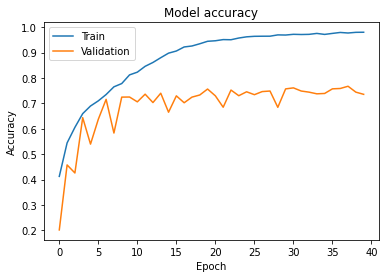

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

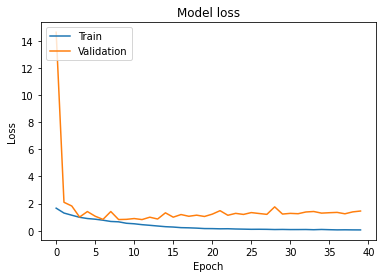

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
loss, accuracy = model.evaluate(test_images, test_labels)

print("Loss on test data:", loss)
print("Accuracy on test data:", accuracy)


313/313 [==============================] - 4s 13ms/step - loss: 1.4790 - accuracy: 0.7333
Loss on test data: 1.4789676666259766
Accuracy on test data: 0.733299970626831
